In [4]:
import os
import re
import json
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import torch

In [2]:
device = "cpu"

In [3]:
def load_json_res(data_dir):
    with open(data_dir) as f:
        rep = json.load(f)
    
    F = rep["FE"]
    F_err = rep["FE_error"]
    
    return {"PCC": [rep["PCC2"]], "F": [float(F)], "F_err": [float(F_err)],
            }

def load_data(data_dir):
    PCC_list = []
    data = []
    for jsonf in os.listdir(data_dir):
        if re.match("^[A-Z]{5}.JSON", jsonf):
            PCC_list.append(jsonf.split(".")[0])
            data.append(pd.DataFrame(load_json_res(data_dir/jsonf)))

    data = pd.concat(data)
    data.reset_index(inplace=True, drop=True)
    return data

In [5]:
dataset_raw = load_data(Path("/Users/arminsh/Documents/FEN-HTVS/results_dec"))
dataset = dataset_raw.copy()
dataset["F"] = -dataset.F
dataset["F_err"] = dataset.F_err
norm_transform = [dataset.F.mean(), dataset.F.std()]
dataset.F_err = dataset.F_err/norm_transform[1]
dataset.F = (dataset.F - norm_transform[0])/norm_transform[1]

In [14]:
BO_DB = pd.read_csv(Path("/Users/arminsh/Documents/FEN-HTVS/results_dec/PCCPCC.csv"))
BO_DB.dropna(inplace=True)
BO_DB = BO_DB.astype({'Round': 'int16'})
BO_DB = BO_DB[BO_DB.Round != 0]

In [15]:
BO_DB

,PCC1,PCC,-Free Energy (kJ/Mol),Error,Round
6,GHGGF,YWDWY,7.80,0.65,5
7,GHGGF,WADLW,5.83,0.24,5
8,GHGGF,WWDFW,8.92,0.64,5
9,GHGGF,WWPWW,7.74,0.35,4
10,GHGGF,HWRWW,5.79,0.38,4
11,GHGGF,WWDWW,8.57,0.36,4
12,GHGGF,HWPLL,5.64,0.30,3
13,GHGGF,WWPLW,8.03,0.40,3
14,GHGGF,HWPVW,6.95,0.37,3
15,GHGGF,HWPLW,10.24,0.77,2


In [48]:
BO_rounds = { str(i): list(BO_DB[BO_DB.Round == i].PCC) for i in sorted(BO_DB.Round.unique())}

In [49]:
BO_rounds

{'1': ['HWPWF', 'YLWWW', 'HRWWW'],
 '2': ['HWPLW', 'HWWAF', 'HHWLF'],
 '3': ['HWPLL', 'WWPLW', 'HWPVW'],
 '4': ['WWPWW', 'HWRWW', 'WWDWW'],
 '5': ['YWDWY', 'WADLW', 'WWDFW']}

In [50]:
def calc_true_metric(dataset, round_n):
    dataset = dataset.copy()
    exclude_list = []
    rounds = [str(i) for i in BO_rounds.keys()]
    for _ in range(round_n):
        rounds.pop(0)
    for key in rounds:
        exclude_list += BO_rounds[key]

    
    dataset = dataset[~dataset.PCC.isin(exclude_list)]

    res = {}

    res['all_data'] = torch.Tensor(dataset.F.to_numpy())
    res['all_data'] = res['all_data']*norm_transform[1] + norm_transform[0]
    res['top1'] = res['all_data'].max()
    res['top10'] = (res["all_data"].topk(10)[0]).mean()

    selected_ds = dataset[dataset.PCC.isin(BO_rounds[str(round_n)])]
    res['selected'] =torch.Tensor(selected_ds.F.to_numpy())
    res['selected'] = res['selected']*norm_transform[1] + norm_transform[0]

    return res

In [51]:
results = {}
for i in BO_rounds.keys():
    results[i] = calc_true_metric(dataset, int(i))

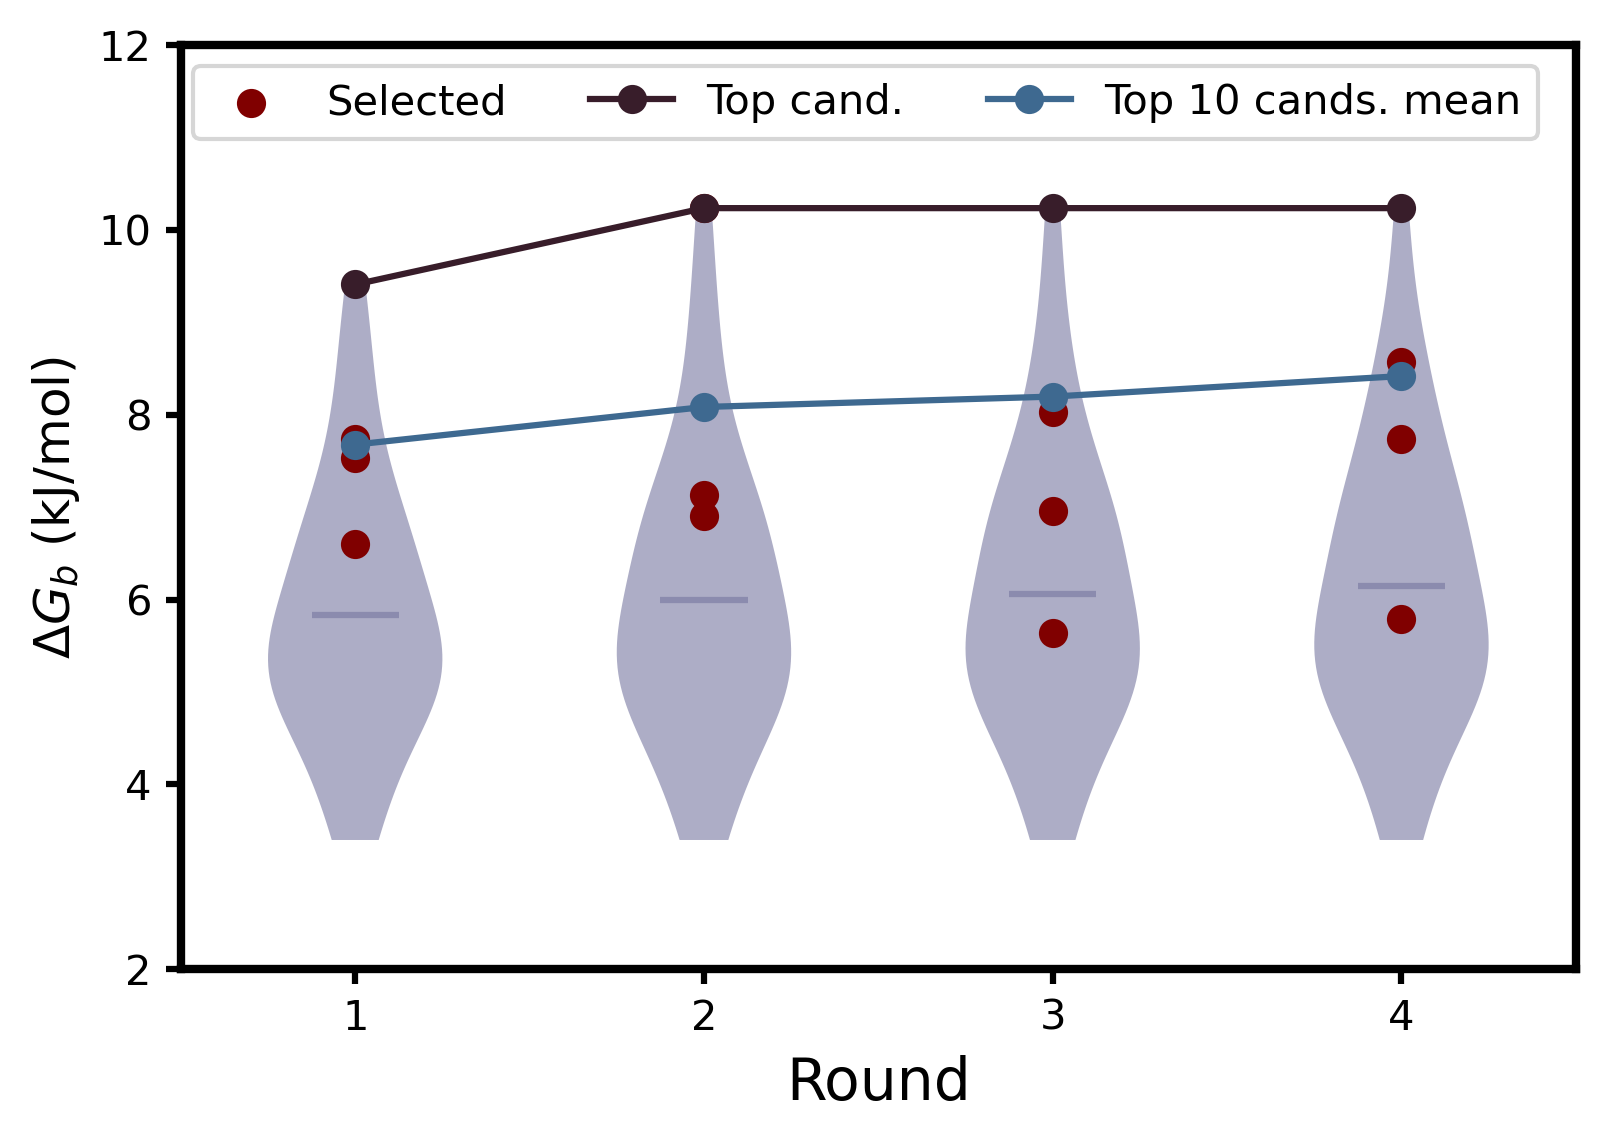

In [55]:
top_cand =  np.array([results[i]['top1'] for i in results.keys()])[:-1]
top_cands =  np.array([results[i]['top10'] for i in results.keys()])[:-1]
all_data = [results[i]['all_data'] for i in results.keys()][:-1]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

xaxis_data = [i for i in range(len(BO_rounds))][:-1]
violin_parts = ax.violinplot(all_data, positions=xaxis_data, showmeans=True, showextrema=False)
for pc in violin_parts['bodies']:
    pc.set_facecolor('#8B8BAE')
    pc.set_alpha(0.7)

violin_parts['cmeans'].set_color('#8B8BAE')

for round in results.keys():
    cands = results[round]['selected']
    ax.scatter(x = [round]*len(cands), y = cands, color='#800000', label="Selected")

ax.plot(top_cand, 'o-', color="#381D2A", label=r"Top cand.")
ax.plot(top_cands, 'o-', color="#3E6990", label=r"Top 10 cands. mean")

ax.set_xticks(xaxis_data, [str(i+1) for i in xaxis_data])
ax.set_xlim(-0.5, max(xaxis_data)+0.5)
ax.set_ylim(2, 12)

ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
for side in ['top', 'bottom', 'left', 'right']:
    ax.spines[side].set(lw=2)
ax.set_xlabel("Round", fontsize=14)
ax.set_ylabel(r"$\Delta G_{b}$ (kJ/mol)", fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend([handles[0], handles[-2], handles[-1]], [labels[0], labels[-2], labels[-1]], loc="upper left", bbox_to_anchor=(0.12, 0.88), ncol=3)
plt.show()